In [1]:
# Importing required libraries

import requests
import json
from google.colab import drive

In [2]:
# Mounting google drive

drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [3]:
!pip install tweet-preprocessor

In [4]:
import preprocessor as pp

In [5]:
!pip install textblob

In [6]:
from textblob import TextBlob

In [7]:
import matplotlib.pyplot as plt
import csv

Size  5000
2484 938 1578


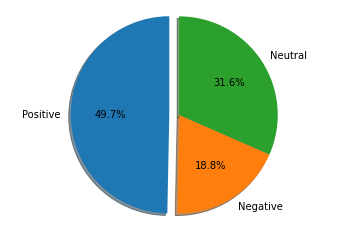

In [9]:
with open('/content/drive/My Drive/Key Files/twitter.json') as json_file:
  key_data = json.load(json_file)


bearer_token = key_data['bearerToken']

search_url = "https://api.twitter.com/2/tweets/search/recent"
query_params = {'query': '(covid vaccine OR corona vaccine OR covid vaccination OR #covidvaccine OR #getvaccinated OR #pfiser OR #astrazeneca OR #covaxin OR #covishield OR #Modena) -is:retweet lang:en','tweet.fields': 'author_id,created_at','max_results': '100'}

def create_headers(bearer_token):
  headers = {"Authorization": "Bearer {}".format(bearer_token)}
  return headers

def connect_endpoint(url, headers, params):
  response = requests.request("GET", search_url, headers=headers, params=params)
  if(response.status_code != 200):
    raise Exception(response.status_code, response.text)
  return response.json()

def get_more_tweets(next_token, headers):
  if(next_token):
    query_params = {'query': '(covid vaccine OR corona vaccine OR covid vaccination OR #covidvaccine OR #getvaccinated OR #pfiser OR #astrazeneca OR #covaxin OR #covishield OR #Modena) -is:retweet lang:en','tweet.fields': 'author_id,created_at','max_results': '100','next_token':next_token}
    response = requests.request("GET", search_url, headers=headers, params=query_params)
    if(response.status_code != 200):
      raise Exception(response.status_code, response.text)
    return response.json()
  return False

def clean_tweets(tweet):
  text = pp.clean(tweet)
  return text.replace(":","") 

def analyse_tweet(tweet):
  text = clean_tweets(tweet)
  analysis = TextBlob(text)
  polarity = analysis.sentiment.polarity
  if(polarity <= -0.5):
    with open('/content/drive/My Drive/My data files/negative.csv','a', newline='') as csvfile:
      fieldnames = ['text']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

      writer.writeheader()
      writer.writerow({'text': text})
  elif(polarity >= 0.5):
    with open('/content/drive/My Drive/My data files/positive.csv','a', newline='') as csvfile:
      fieldnames = ['text']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

      writer.writeheader()
      writer.writerow({'text': text})
  else:
    with open('/content/drive/My Drive/My data files/neutral.csv','a', newline='') as csvfile:
      fieldnames = ['text']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

      writer.writeheader()
      writer.writerow({'text': text})
  return polarity

def plot_bar(positive_count, negative_count, neutral_count):
  x = [positive_count, neutral_count, negative_count]
  labels = ["Positive", "Neutral", "Negative"]
  plt.bar(labels,x)
  plt.show()

def plot_pie(positive_count, negative_count, neutral_count):
  labels = ['Positive', 'Negative', 'Neutral']
  sum = positive_count + negative_count + neutral_count
  positive_percent = (positive_count/sum) * 100
  negative_percent = (negative_count/sum) * 100
  neutral_percent = (neutral_count/sum) * 100
  values = [positive_percent, negative_percent, neutral_percent]
  explode = (0.1,0,0)
  fig1, ax1 = plt.subplots()
  ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')  
  plt.show()

def main():
  tweets = []
  headers = create_headers(bearer_token)
  json_response = connect_endpoint(search_url,headers, query_params)
  tweets = tweets + json_response["data"]
  while(len(tweets) < 5000):
    json_response = get_more_tweets(json_response["meta"]["next_token"], headers)
    if(json_response == False):
      break
    tweets = tweets + json_response["data"]
  print("Size ",len(tweets))
  positive_count = 0
  negative_count = 0
  neutral_count = 0
  for i in tweets:
    result = analyse_tweet(i["text"])
    if(result > 0):
      positive_count += 1
    elif(result < 0):
      negative_count += 1
    else:
      neutral_count += 1
  print(positive_count, negative_count, neutral_count)
  plot_bar(positive_count, negative_count, neutral_count)
  plot_pie(positive_count, negative_count, neutral_count)


if __name__ == "__main__":
  main()


